In [ ]:
import bs4 as bs
import requests

resp = requests.get('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
soup = bs.BeautifulSoup(resp.text, 'html.parser')  # 'html.parser' instead of 'lxml'

# Locate the table with S&P 500 tickers
table = soup.find('table', {'id': 'constituents'})  # More reliable ID selector

tickers = []
for row in table.findAll('tr')[1:]:  # Skip the first row (header)
    cells = row.findAll('td')
    
    if len(cells) > 0:  # Ensure there is at least one <td> in the row
        ticker = cells[0].text.strip()  # Strip whitespace/newline
        tickers.append(ticker)
    else:
        print(f"Skipping empty row: {row}")

print(f"Extracted {len(tickers)} S&P 500 tickers.")

Extracted 503 S&P 500 tickers.


## 主要逻辑
首先，代码从维基百科网页爬取S&P 500成分股的股票代码。使用BeautifulSoup解析HTML，定位到ID为"constituents"的表格，并从中提取所有股票代码。

用了另一个library叫yahooquery，In my trial the time reduced from 34 seconds to 0.4 seconds.
There are lots of other information in the myDict {} dictionary, 如果需要更多的数据可以从中提取

接着，将所有股票代码分成多个批次（每批10个），以避免同时请求过多数据触发API限制。程序会创建一个名为"sp500_batches"的目录用于存储各批次的CSV文件。

对于每支股票，代码使用yahooquery库获取以下数据：
- 5年的历史价格数据（每日间隔）
- 关键统计数据（如流通股数）
- 详细摘要信息（如市值）
- 公司概况（如行业分类）

处理过程中计算了几个重要指标：
- 日收益率（基于调整后收盘价）
- 交易率（成交量/流通股数）
- 账面市值比（总账面价值/市值）

还实现了指数退避重试机制，以处理API请求失败的情况，并添加了随机延迟，避免触发请求频率限制。

最终，将处理后的数据合并为一个DataFrame，并保存为CSV文件，文件名包含批次号以便识别。

In [ ]:
import time
import random
import pandas as pd
from yahooquery import Ticker
import os

# Split into 51 batches (each batch has 10 tickers)
batch_size = 10
ticker_batches = [tickers[i:i+batch_size] for i in range(0, len(tickers), batch_size)]

# Make sure a directory exists to store batch CSV files
os.makedirs("sp500_batches", exist_ok=True)

# Get the batch number from the user (e.g., run for batch 1, then batch 2, etc.)
batch_number = int(input(f"Enter batch number (1-{len(ticker_batches)}): "))  # Run each batch separately
if batch_number < 1 or batch_number > len(ticker_batches):
    print("Invalid batch number. Exiting.")
    exit()

# Select tickers for the current batch
batch_tickers = ticker_batches[batch_number - 1]  # Convert to 0-based index

print(f"Processing batch {batch_number} with tickers: {batch_tickers}")

# Fetch snapshot data
all_tickers = Ticker(batch_tickers)
myDict = all_tickers.price
key_stats = all_tickers.key_stats
summary_detail = all_tickers.summary_detail
summary_profile = all_tickers.summary_profile

def fetch_history_with_retry(ticker, period="5y", interval="1d", max_retries=5):
    """
    Fetch historical data with retries and exponential backoff
    """
    for attempt in range(max_retries):
        try:
            t = Ticker(ticker)
            hist = t.history(period=period, interval=interval)
            if isinstance(hist, pd.DataFrame) and not hist.empty:
                return hist.reset_index()
            else:
                time.sleep(2 ** attempt)
        except Exception as e:
            print(f"{ticker} attempt {attempt + 1} failed: {e}")
            time.sleep(2 ** attempt)
    return None

results = []

for ticker in batch_tickers:
    if not isinstance(ticker, str):
        print(f"Skipping invalid ticker: {ticker}")
        continue

    print(f"Processing {ticker} ...")
    time.sleep(random.uniform(3, 7))  # Random delay to avoid rate limits

    hist_df = fetch_history_with_retry(ticker, period="5y", interval="1d", max_retries=5)
    if hist_df is None or hist_df.empty:
        print(f"No historical data for {ticker}, skipping.")
        continue

    # Compute daily return
    hist_df["Return"] = hist_df["adjclose"].pct_change()

    # Get sharesOutstanding
    shares_out = key_stats.get(ticker, {}).get("sharesOutstanding", None)
    if shares_out is None:
        shares_out = myDict.get(ticker, {}).get("sharesOutstanding", None)

    # Compute transaction rate = volume / sharesOutstanding
    if shares_out and shares_out > 0:
        hist_df["Transaction_Rate"] = hist_df["volume"] / shares_out
    else:
        hist_df["Transaction_Rate"] = None

    # Compute Book-to-Market Ratio
    book_value_per_share = key_stats.get(ticker, {}).get("bookValue", None)
    if book_value_per_share is None:
        book_value_per_share = myDict.get(ticker, {}).get("bookValue", None)
    market_cap = summary_detail.get(ticker, {}).get("marketCap", None)
    if market_cap is None:
        market_cap = myDict.get(ticker, {}).get("marketCap", None)
    if book_value_per_share and shares_out and market_cap and shares_out > 0 and market_cap > 0:
        total_book_value = book_value_per_share * shares_out
        hist_df["Book_to_Market"] = total_book_value / market_cap
    else:
        hist_df["Book_to_Market"] = None

    # Get Sector & Industry
    sector = summary_profile.get(ticker, {}).get("sector", None)
    industry = summary_profile.get(ticker, {}).get("industry", None)
    hist_df["Sector"] = sector
    hist_df["Industry"] = industry

    # Add ticker column
    hist_df["Ticker"] = ticker

    results.append(hist_df)

# Save batch data
if results:
    batch_df = pd.concat(results, ignore_index=True)
    batch_filename = f"sp500_batches/batch_{batch_number}.csv"
    batch_df.to_csv(batch_filename, index=False)
    print(f"Batch {batch_number} data saved to {batch_filename}")
else:
    print(f"No data processed for batch {batch_number}.")


Processing batch 2 with tickers: ['APD', 'ABNB', 'AKAM', 'ALB', 'ARE', 'ALGN', 'ALLE', 'LNT', 'ALL', 'GOOGL']
Processing APD ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing ABNB ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")


Processing AKAM ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")


Processing ALB ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing ARE ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing ALGN ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")


Processing ALLE ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing LNT ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing ALL ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing GOOGL ...
Batch 2 data saved to sp500_batches/batch_2.csv


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)
/Library/Frameworks/Python.framework/Versions/3.

In [10]:
import time
import random
import pandas as pd
import os
from yahooquery import Ticker

import bs4 as bs
import requests

resp = requests.get('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
soup = bs.BeautifulSoup(resp.text, 'html.parser')  # 'html.parser' instead of 'lxml'

# Locate the table with S&P 500 tickers
table = soup.find('table', {'id': 'constituents'})  # More reliable ID selector

tickers = []
for row in table.findAll('tr')[1:]:  # Skip the first row (header)
    cells = row.findAll('td')
    
    if len(cells) > 0:  # Ensure there is at least one <td> in the row
        ticker = cells[0].text.strip()  # Strip whitespace/newline
        tickers.append(ticker)
    else:
        print(f"Skipping empty row: {row}")

print(f"Extracted {len(tickers)} S&P 500 tickers.")


# ✅ Split into batches (each batch = 10 tickers)
batch_size = 10
ticker_batches = [tickers[i:i + batch_size] for i in range(0, len(tickers), batch_size)]

# ✅ Ensure output directory exists
os.makedirs("sp500_batches", exist_ok=True)

# ✅ Automatically loop through batch 3 to 51
for batch_number in range(1, 52):  # Runs batch 3 to 51
    batch_tickers = ticker_batches[batch_number - 1]  # Convert to 0-based index
    batch_filename = f"sp500_batches/batch_{batch_number}.csv"

    # ✅ Skip if the batch file already exists (prevents reprocessing)
    if os.path.exists(batch_filename):
        print(f"Batch {batch_number} already processed. Skipping...")
        continue

    print(f"Processing batch {batch_number} with tickers: {batch_tickers}")

    # ✅ Fetch snapshot data
    all_tickers = Ticker(batch_tickers)
    myDict = all_tickers.price
    key_stats = all_tickers.key_stats
    summary_detail = all_tickers.summary_detail
    summary_profile = all_tickers.summary_profile

    def fetch_history_with_retry(ticker, period="5y", interval="1d", max_retries=5):
        """
        Fetch historical data with retries and exponential backoff
        """
        for attempt in range(max_retries):
            try:
                t = Ticker(ticker)
                hist = t.history(period=period, interval=interval)
                if isinstance(hist, pd.DataFrame) and not hist.empty:
                    return hist.reset_index()
                else:
                    time.sleep(2 ** attempt)
            except Exception as e:
                print(f"{ticker} attempt {attempt + 1} failed: {e}")
                time.sleep(2 ** attempt)
        return None

    results = []

    for ticker in batch_tickers:
        print(f"Processing {ticker} ...")
        time.sleep(random.uniform(3, 7))  # Random delay to avoid rate limits

        hist_df = fetch_history_with_retry(ticker, period="5y", interval="1d", max_retries=5)
        if hist_df is None or hist_df.empty:
            print(f"No historical data for {ticker}, skipping.")
            continue

        # ✅ Compute daily return
        hist_df["Return"] = hist_df["adjclose"].pct_change()

        # ✅ Get sharesOutstanding
        shares_out = key_stats.get(ticker, {}).get("sharesOutstanding", None)
        if shares_out is None:
            shares_out = myDict.get(ticker, {}).get("sharesOutstanding", None)

        # ✅ Compute transaction rate = volume / sharesOutstanding
        if shares_out and shares_out > 0:
            hist_df["Transaction_Rate"] = hist_df["volume"] / shares_out
        else:
            hist_df["Transaction_Rate"] = None

        # ✅ Compute Book-to-Market Ratio
        book_value_per_share = key_stats.get(ticker, {}).get("bookValue", None)
        if book_value_per_share is None:
            book_value_per_share = myDict.get(ticker, {}).get("bookValue", None)
        market_cap = summary_detail.get(ticker, {}).get("marketCap", None)
        if market_cap is None:
            market_cap = myDict.get(ticker, {}).get("marketCap", None)
        if book_value_per_share and shares_out and market_cap and shares_out > 0 and market_cap > 0:
            total_book_value = book_value_per_share * shares_out
            hist_df["Book_to_Market"] = total_book_value / market_cap
        else:
            hist_df["Book_to_Market"] = None

        # ✅ Get Sector & Industry
        sector = summary_profile.get(ticker, {}).get("sector", None)
        industry = summary_profile.get(ticker, {}).get("industry", None)
        hist_df["Sector"] = sector
        hist_df["Industry"] = industry

        # ✅ Add ticker column
        hist_df["Ticker"] = ticker

        results.append(hist_df)

    # ✅ Save batch data
    if results:
        batch_df = pd.concat(results, ignore_index=True)
        batch_df.to_csv(batch_filename, index=False)
        print(f"Batch {batch_number} data saved to {batch_filename}")
    else:
        print(f"No data processed for batch {batch_number}.")

    # ✅ Random wait before next batch (to avoid API rate limits)
    time.sleep(random.uniform(15, 30))  # Adjust as needed


Extracted 503 S&P 500 tickers.
Batch 3 already processed. Skipping...
Batch 4 already processed. Skipping...
Processing batch 5 with tickers: ['AMAT', 'APTV', 'ACGL', 'ADM', 'ANET', 'AJG', 'AIZ', 'T', 'ATO', 'ADSK']
Processing AMAT ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing APTV ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")


Processing ACGL ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing ADM ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing ANET ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1335: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["splits"].fillna(0, inplace=True)


Processing AJG ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing AIZ ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing T ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)
/Library/Frameworks/Python.framework/Versions/3.

Processing ATO ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing ADSK ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")


Batch 5 data saved to sp500_batches/batch_5.csv
Processing batch 6 with tickers: ['ADP', 'AZO', 'AVB', 'AVY', 'AXON', 'BKR', 'BALL', 'BAC', 'BAX', 'BDX']
Processing ADP ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing AZO ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")


Processing AVB ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing AVY ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing AXON ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")


Processing BKR ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing BALL ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing BAC ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing BAX ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing BDX ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)
/Library/Frameworks/Python.framework/Versions/3.

Batch 6 data saved to sp500_batches/batch_6.csv
Processing batch 7 with tickers: ['BRK.B', 'BBY', 'TECH', 'BIIB', 'BLK', 'BX', 'BK', 'BA', 'BKNG', 'BWA']
Processing BRK.B ...
No historical data for BRK.B, skipping.
Processing BBY ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing TECH ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)
/Library/Frameworks/Python.framework/Versions/3.

Processing BIIB ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")


Processing BLK ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing BX ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing BK ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing BA ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")


Processing BKNG ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing BWA ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)
/Library/Frameworks/Python.framework/Versions/3.

Batch 7 data saved to sp500_batches/batch_7.csv
Processing batch 8 with tickers: ['BSX', 'BMY', 'AVGO', 'BR', 'BRO', 'BF.B', 'BLDR', 'BG', 'BXP', 'CHRW']
Processing BSX ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")


Processing BMY ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing AVGO ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)
/Library/Frameworks/Python.framework/Versions/3.

Processing BR ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing BRO ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing BF.B ...
No historical data for BF.B, skipping.
Processing BLDR ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")


Processing BG ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing BXP ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing CHRW ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Batch 8 data saved to sp500_batches/batch_8.csv
Processing batch 9 with tickers: ['CDNS', 'CZR', 'CPT', 'CPB', 'COF', 'CAH', 'KMX', 'CCL', 'CARR', 'CAT']
Processing CDNS ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")


Processing CZR ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")


Processing CPT ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing CPB ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing COF ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing CAH ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing KMX ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")


Processing CCL ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")


Processing CARR ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing CAT ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Batch 9 data saved to sp500_batches/batch_9.csv
Processing batch 10 with tickers: ['CBOE', 'CBRE', 'CDW', 'CE', 'COR', 'CNC', 'CNP', 'CF', 'CRL', 'SCHW']
Processing CBOE ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing CBRE ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")


Processing CDW ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing CE ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing COR ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing CNC ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")


Processing CNP ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing CF ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing CRL ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")


Processing SCHW ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Batch 10 data saved to sp500_batches/batch_10.csv
Processing batch 11 with tickers: ['CHTR', 'CVX', 'CMG', 'CB', 'CHD', 'CI', 'CINF', 'CTAS', 'CSCO', 'C']
Processing CHTR ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")


Processing CVX ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing CMG ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1335: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["splits"].fillna(0, inplace=True)


Processing CB ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing CHD ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing CI ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing CINF ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing CTAS ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)
/Library/Frameworks/Python.framework/Versions/3.

Processing CSCO ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing C ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Batch 11 data saved to sp500_batches/batch_11.csv
Processing batch 12 with tickers: ['CFG', 'CLX', 'CME', 'CMS', 'KO', 'CTSH', 'CL', 'CMCSA', 'CAG', 'COP']
Processing CFG ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing CLX ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing CME ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing CMS ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing KO ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing CTSH ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing CL ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing CMCSA ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing CAG ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing COP ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Batch 12 data saved to sp500_batches/batch_12.csv
Processing batch 13 with tickers: ['ED', 'STZ', 'CEG', 'COO', 'CPRT', 'GLW', 'CPAY', 'CTVA', 'CSGP', 'COST']
Processing ED ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing STZ ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing CEG ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing COO ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)
/Library/Frameworks/Python.framework/Versions/3.

Processing CPRT ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1335: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["splits"].fillna(0, inplace=True)


Processing GLW ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing CPAY ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")


Processing CTVA ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing CSGP ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1335: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["splits"].fillna(0, inplace=True)


Processing COST ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Batch 13 data saved to sp500_batches/batch_13.csv
Processing batch 14 with tickers: ['CTRA', 'CRWD', 'CCI', 'CSX', 'CMI', 'CVS', 'DHR', 'DRI', 'DVA', 'DAY']
Processing CTRA ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing CRWD ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")


Processing CCI ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing CSX ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)
/Library/Frameworks/Python.framework/Versions/3.

Processing CMI ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing CVS ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing DHR ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)
/Library/Frameworks/Python.framework/Versions/3.

Processing DRI ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing DVA ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")


Processing DAY ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")


Batch 14 data saved to sp500_batches/batch_14.csv
Processing batch 15 with tickers: ['DECK', 'DE', 'DELL', 'DAL', 'DVN', 'DXCM', 'FANG', 'DLR', 'DFS', 'DG']
Processing DECK ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1335: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["splits"].fillna(0, inplace=True)


Processing DE ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing DELL ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)
/Library/Frameworks/Python.framework/Versions/3.

Processing DAL ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing DVN ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing DXCM ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1335: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["splits"].fillna(0, inplace=True)


Processing FANG ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing DLR ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing DFS ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing DG ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Batch 15 data saved to sp500_batches/batch_15.csv
Processing batch 16 with tickers: ['DLTR', 'D', 'DPZ', 'DOV', 'DOW', 'DHI', 'DTE', 'DUK', 'DD', 'EMN']
Processing DLTR ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")


Processing D ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing DPZ ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing DOV ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing DOW ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing DHI ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing DTE ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)
/Library/Frameworks/Python.framework/Versions/3.

Processing DUK ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing DD ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing EMN ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Batch 16 data saved to sp500_batches/batch_16.csv
Processing batch 17 with tickers: ['ETN', 'EBAY', 'ECL', 'EIX', 'EW', 'EA', 'ELV', 'EMR', 'ENPH', 'ETR']
Processing ETN ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing EBAY ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing ECL ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing EIX ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing EW ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1335: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["splits"].fillna(0, inplace=True)


Processing EA ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing ELV ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing EMR ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing ENPH ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")


Processing ETR ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)
/Library/Frameworks/Python.framework/Versions/3.

Batch 17 data saved to sp500_batches/batch_17.csv
Processing batch 18 with tickers: ['EOG', 'EPAM', 'EQT', 'EFX', 'EQIX', 'EQR', 'ERIE', 'ESS', 'EL', 'EG']
Processing EOG ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing EPAM ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")


Processing EQT ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing EFX ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing EQIX ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing EQR ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing ERIE ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing ESS ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing EL ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing EG ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Batch 18 data saved to sp500_batches/batch_18.csv
Processing batch 19 with tickers: ['EVRG', 'ES', 'EXC', 'EXPE', 'EXPD', 'EXR', 'XOM', 'FFIV', 'FDS', 'FICO']
Processing EVRG ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing ES ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing EXC ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)
/Library/Frameworks/Python.framework/Versions/3.

Processing EXPE ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing EXPD ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing EXR ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing XOM ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing FFIV ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")


Processing FDS ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing FICO ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")


Batch 19 data saved to sp500_batches/batch_19.csv
Processing batch 20 with tickers: ['FAST', 'FRT', 'FDX', 'FIS', 'FITB', 'FSLR', 'FE', 'FI', 'FMC', 'F']
Processing FAST ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing FRT ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing FDX ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing FIS ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing FITB ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing FSLR ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")


Processing FE ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing FI ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")


Processing FMC ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing F ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Batch 20 data saved to sp500_batches/batch_20.csv
Processing batch 21 with tickers: ['FTNT', 'FTV', 'FOXA', 'FOX', 'BEN', 'FCX', 'GRMN', 'IT', 'GE', 'GEHC']
Processing FTNT ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1335: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["splits"].fillna(0, inplace=True)


Processing FTV ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)
/Library/Frameworks/Python.framework/Versions/3.

Processing FOXA ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing FOX ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing BEN ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing FCX ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing GRMN ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing IT ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")


Processing GE ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)
/Library/Frameworks/Python.framework/Versions/3.

Processing GEHC ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Batch 21 data saved to sp500_batches/batch_21.csv
Processing batch 22 with tickers: ['GEV', 'GEN', 'GNRC', 'GD', 'GIS', 'GM', 'GPC', 'GILD', 'GPN', 'GL']
Processing GEV ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing GEN ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing GNRC ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")


Processing GD ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing GIS ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing GM ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing GPC ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing GILD ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing GPN ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing GL ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Batch 22 data saved to sp500_batches/batch_22.csv
Processing batch 23 with tickers: ['GDDY', 'GS', 'HAL', 'HIG', 'HAS', 'HCA', 'DOC', 'HSIC', 'HSY', 'HES']
Processing GDDY ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")


Processing GS ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing HAL ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing HIG ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing HAS ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing HCA ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing DOC ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing HSIC ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")


Processing HSY ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing HES ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Batch 23 data saved to sp500_batches/batch_23.csv
Processing batch 24 with tickers: ['HPE', 'HLT', 'HOLX', 'HD', 'HON', 'HRL', 'HST', 'HWM', 'HPQ', 'HUBB']
Processing HPE ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing HLT ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing HOLX ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")


Processing HD ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing HON ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing HRL ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing HST ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing HWM ...
HWM attempt 1 failed: HTTPSConnectionPool(host='query2.finance.yahoo.com', port=443): Max retries exceeded with url: /v8/finance/chart/HWM?range=5y&interval=1d&events=div%2Csplit&formatted=false&lang=en-US&region=US&corsDomain=finance.yahoo.com&crumb=UMxMSHC2X7K (Caused by ResponseError('too many 500 error responses'))
HWM attempt 2 failed: HTTPSConnectionPool(host='query2.finance.yahoo.com', port=443): Max retries exceeded with url: /v8/finance/chart/HWM?range=5y&interval=1d&events=div%2Csplit&formatted=false&lang=en-US&region=US&corsDomain=finance.yahoo.com&crumb=vfjo9yY5BQj (Caused by ResponseError('too many 500 error responses'))
HWM attempt 3 failed: HTTPSConnectionPool(host='query2.finance.yahoo.com', port=443): Max retries exceeded with url: /v8/finance/chart/HWM?range=5y&interval=1d&events=div%2Csplit&formatted=false&lang=en-US&region=US&corsDomain=finance.yahoo.com&crumb=dV2xWvZns95 (Caused by ResponseError('too many 500 error responses'))
HWM attempt 4 fail

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing HUBB ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Batch 24 data saved to sp500_batches/batch_24.csv
Processing batch 25 with tickers: ['HUM', 'HBAN', 'HII', 'IBM', 'IEX', 'IDXX', 'ITW', 'INCY', 'IR', 'PODD']
Processing HUM ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing HBAN ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing HII ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing IBM ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)
/Library/Frameworks/Python.framework/Versions/3.

Processing IEX ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing IDXX ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")


Processing ITW ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing INCY ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")


Processing IR ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing PODD ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")


Batch 25 data saved to sp500_batches/batch_25.csv
Processing batch 26 with tickers: ['INTC', 'ICE', 'IFF', 'IP', 'IPG', 'INTU', 'ISRG', 'IVZ', 'INVH', 'IQV']
Processing INTC ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing ICE ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing IFF ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing IP ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)
/Library/Frameworks/Python.framework/Versions/3.

Processing IPG ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing INTU ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing ISRG ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1335: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["splits"].fillna(0, inplace=True)


Processing IVZ ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing INVH ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing IQV ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")


Batch 26 data saved to sp500_batches/batch_26.csv
Processing batch 27 with tickers: ['IRM', 'JBHT', 'JBL', 'JKHY', 'J', 'JNJ', 'JCI', 'JPM', 'JNPR', 'K']
Processing IRM ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing JBHT ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing JBL ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing JKHY ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing J ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)
/Library/Frameworks/Python.framework/Versions/3.

Processing JNJ ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing JCI ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing JPM ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing JNPR ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing K ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)
/Library/Frameworks/Python.framework/Versions/3.

Batch 27 data saved to sp500_batches/batch_27.csv
Processing batch 28 with tickers: ['KVUE', 'KDP', 'KEY', 'KEYS', 'KMB', 'KIM', 'KMI', 'KKR', 'KLAC', 'KHC']
Processing KVUE ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing KDP ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing KEY ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing KEYS ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")


Processing KMB ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing KIM ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing KMI ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing KKR ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing KLAC ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing KHC ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Batch 28 data saved to sp500_batches/batch_28.csv
Processing batch 29 with tickers: ['KR', 'LHX', 'LH', 'LRCX', 'LW', 'LVS', 'LDOS', 'LEN', 'LII', 'LLY']
Processing KR ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing LHX ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing LH ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)
/Library/Frameworks/Python.framework/Versions/3.

Processing LRCX ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)
/Library/Frameworks/Python.framework/Versions/3.

Processing LW ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing LVS ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing LDOS ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing LEN ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)
/Library/Frameworks/Python.framework/Versions/3.

Processing LII ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing LLY ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Batch 29 data saved to sp500_batches/batch_29.csv
Processing batch 30 with tickers: ['LIN', 'LYV', 'LKQ', 'LMT', 'L', 'LOW', 'LULU', 'LYB', 'MTB', 'MPC']
Processing LIN ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing LYV ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")


Processing LKQ ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing LMT ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing L ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing LOW ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing LULU ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")


Processing LYB ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing MTB ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing MPC ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Batch 30 data saved to sp500_batches/batch_30.csv
Processing batch 31 with tickers: ['MKTX', 'MAR', 'MMC', 'MLM', 'MAS', 'MA', 'MTCH', 'MKC', 'MCD', 'MCK']
Processing MKTX ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing MAR ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing MMC ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing MLM ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing MAS ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing MA ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing MTCH ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)
/Library/Frameworks/Python.framework/Versions/3.

Processing MKC ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)
/Library/Frameworks/Python.framework/Versions/3.

Processing MCD ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing MCK ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Batch 31 data saved to sp500_batches/batch_31.csv
Processing batch 32 with tickers: ['MDT', 'MRK', 'META', 'MET', 'MTD', 'MGM', 'MCHP', 'MU', 'MSFT', 'MAA']
Processing MDT ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing MRK ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)
/Library/Frameworks/Python.framework/Versions/3.

Processing META ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing MET ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing MTD ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")


Processing MGM ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing MCHP ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)
/Library/Frameworks/Python.framework/Versions/3.

Processing MU ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing MSFT ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing MAA ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Batch 32 data saved to sp500_batches/batch_32.csv
Processing batch 33 with tickers: ['MRNA', 'MHK', 'MOH', 'TAP', 'MDLZ', 'MPWR', 'MNST', 'MCO', 'MS', 'MOS']
Processing MRNA ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")


Processing MHK ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")


Processing MOH ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")


Processing TAP ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing MDLZ ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing MPWR ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing MNST ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1335: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["splits"].fillna(0, inplace=True)


Processing MCO ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing MS ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing MOS ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Batch 33 data saved to sp500_batches/batch_33.csv
Processing batch 34 with tickers: ['MSI', 'MSCI', 'NDAQ', 'NTAP', 'NFLX', 'NEM', 'NWSA', 'NWS', 'NEE', 'NKE']
Processing MSI ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing MSCI ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing NDAQ ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)
/Library/Frameworks/Python.framework/Versions/3.

Processing NTAP ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing NFLX ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")


Processing NEM ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing NWSA ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing NWS ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing NEE ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)
/Library/Frameworks/Python.framework/Versions/3.

Processing NKE ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Batch 34 data saved to sp500_batches/batch_34.csv
Processing batch 35 with tickers: ['NI', 'NDSN', 'NSC', 'NTRS', 'NOC', 'NCLH', 'NRG', 'NUE', 'NVDA', 'NVR']
Processing NI ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing NDSN ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing NSC ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing NTRS ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing NOC ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing NCLH ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")


Processing NRG ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing NUE ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing NVDA ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)
/Library/Frameworks/Python.framework/Versions/3.

Processing NVR ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")


Batch 35 data saved to sp500_batches/batch_35.csv
Processing batch 36 with tickers: ['NXPI', 'ORLY', 'OXY', 'ODFL', 'OMC', 'ON', 'OKE', 'ORCL', 'OTIS', 'PCAR']
Processing NXPI ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing ORLY ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")


Processing OXY ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing ODFL ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)
/Library/Frameworks/Python.framework/Versions/3.

Processing OMC ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing ON ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")


Processing OKE ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing ORCL ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing OTIS ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing PCAR ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)
/Library/Frameworks/Python.framework/Versions/3.

Batch 36 data saved to sp500_batches/batch_36.csv
Processing batch 37 with tickers: ['PKG', 'PLTR', 'PANW', 'PARA', 'PH', 'PAYX', 'PAYC', 'PYPL', 'PNR', 'PEP']
Processing PKG ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing PLTR ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")


Processing PANW ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1335: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["splits"].fillna(0, inplace=True)


Processing PARA ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing PH ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing PAYX ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing PAYC ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing PYPL ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")


Processing PNR ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing PEP ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Batch 37 data saved to sp500_batches/batch_37.csv
Processing batch 38 with tickers: ['PFE', 'PCG', 'PM', 'PSX', 'PNW', 'PNC', 'POOL', 'PPG', 'PPL', 'PFG']
Processing PFE ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)
/Library/Frameworks/Python.framework/Versions/3.

Processing PCG ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing PM ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing PSX ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing PNW ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing PNC ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing POOL ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing PPG ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing PPL ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing PFG ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Batch 38 data saved to sp500_batches/batch_38.csv
Processing batch 39 with tickers: ['PG', 'PGR', 'PLD', 'PRU', 'PEG', 'PTC', 'PSA', 'PHM', 'PWR', 'QCOM']
Processing PG ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing PGR ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing PLD ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing PRU ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing PEG ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing PTC ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")


Processing PSA ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing PHM ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing PWR ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing QCOM ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Batch 39 data saved to sp500_batches/batch_39.csv
Processing batch 40 with tickers: ['DGX', 'RL', 'RJF', 'RTX', 'O', 'REG', 'REGN', 'RF', 'RSG', 'RMD']
Processing DGX ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing RL ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing RJF ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)
/Library/Frameworks/Python.framework/Versions/3.

Processing RTX ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)
/Library/Frameworks/Python.framework/Versions/3.

Processing O ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)
/Library/Frameworks/Python.framework/Versions/3.

Processing REG ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing REGN ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing RF ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing RSG ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing RMD ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Batch 40 data saved to sp500_batches/batch_40.csv
Processing batch 41 with tickers: ['RVTY', 'ROK', 'ROL', 'ROP', 'ROST', 'RCL', 'SPGI', 'CRM', 'SBAC', 'SLB']
Processing RVTY ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing ROK ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing ROL ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)
/Library/Frameworks/Python.framework/Versions/3.

Processing ROP ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing ROST ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing RCL ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing SPGI ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing CRM ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing SBAC ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing SLB ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Batch 41 data saved to sp500_batches/batch_41.csv
Processing batch 42 with tickers: ['STX', 'SRE', 'NOW', 'SHW', 'SPG', 'SWKS', 'SJM', 'SW', 'SNA', 'SOLV']
Processing STX ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing SRE ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)
/Library/Frameworks/Python.framework/Versions/3.

Processing NOW ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")


Processing SHW ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)
/Library/Frameworks/Python.framework/Versions/3.

Processing SPG ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing SWKS ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing SJM ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing SW ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing SNA ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing SOLV ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")


Batch 42 data saved to sp500_batches/batch_42.csv
Processing batch 43 with tickers: ['SO', 'LUV', 'SWK', 'SBUX', 'STT', 'STLD', 'STE', 'SYK', 'SMCI', 'SYF']
Processing SO ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing LUV ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing SWK ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing SBUX ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing STT ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing STLD ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing STE ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing SYK ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing SMCI ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1335: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["splits"].fillna(0, inplace=True)


Processing SYF ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Batch 43 data saved to sp500_batches/batch_43.csv
Processing batch 44 with tickers: ['SNPS', 'SYY', 'TMUS', 'TROW', 'TTWO', 'TPR', 'TRGP', 'TGT', 'TEL', 'TDY']
Processing SNPS ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")


Processing SYY ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing TMUS ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing TROW ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing TTWO ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")


Processing TPR ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing TRGP ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing TGT ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing TEL ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing TDY ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")


Batch 44 data saved to sp500_batches/batch_44.csv
Processing batch 45 with tickers: ['TFX', 'TER', 'TSLA', 'TXN', 'TPL', 'TXT', 'TMO', 'TJX', 'TSCO', 'TT']
Processing TFX ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing TER ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing TSLA ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1335: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["splits"].fillna(0, inplace=True)


Processing TXN ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing TPL ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)
/Library/Frameworks/Python.framework/Versions/3.

Processing TXT ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing TMO ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing TJX ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing TSCO ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)
/Library/Frameworks/Python.framework/Versions/3.

Processing TT ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Batch 45 data saved to sp500_batches/batch_45.csv
Processing batch 46 with tickers: ['TDG', 'TRV', 'TRMB', 'TFC', 'TYL', 'TSN', 'USB', 'UBER', 'UDR', 'ULTA']
Processing TDG ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing TRV ...
TRV attempt 1 failed: Response ended prematurely


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing TRMB ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")


Processing TFC ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing TYL ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")


Processing TSN ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing USB ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing UBER ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")


Processing UDR ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing ULTA ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")


Batch 46 data saved to sp500_batches/batch_46.csv
Processing batch 47 with tickers: ['UNP', 'UAL', 'UPS', 'URI', 'UNH', 'UHS', 'VLO', 'VTR', 'VLTO', 'VRSN']
Processing UNP ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing UAL ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")


Processing UPS ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing URI ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing UNH ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing UHS ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing VLO ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing VTR ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing VLTO ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing VRSN ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")


Batch 47 data saved to sp500_batches/batch_47.csv
Processing batch 48 with tickers: ['VRSK', 'VZ', 'VRTX', 'VTRS', 'VICI', 'V', 'VST', 'VMC', 'WRB', 'GWW']
Processing VRSK ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing VZ ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing VRTX ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")


Processing VTRS ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing VICI ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing V ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing VST ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing VMC ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing WRB ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)
/Library/Frameworks/Python.framework/Versions/3.

Processing GWW ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Batch 48 data saved to sp500_batches/batch_48.csv
Processing batch 49 with tickers: ['WAB', 'WBA', 'WMT', 'DIS', 'WBD', 'WM', 'WAT', 'WEC', 'WFC', 'WELL']
Processing WAB ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing WBA ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing WMT ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)
/Library/Frameworks/Python.framework/Versions/3.

Processing DIS ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing WBD ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")


Processing WM ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing WAT ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")


Processing WEC ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing WFC ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing WELL ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Batch 49 data saved to sp500_batches/batch_49.csv
Processing batch 50 with tickers: ['WST', 'WDC', 'WY', 'WMB', 'WTW', 'WDAY', 'WYNN', 'XEL', 'XYL', 'YUM']
Processing WST ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing WDC ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)
/Library/Frameworks/Python.framework/Versions/3.

Processing WY ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing WMB ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing WTW ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing WDAY ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")


Processing WYNN ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing XEL ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing XYL ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Processing YUM ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Batch 50 data saved to sp500_batches/batch_50.csv
Processing batch 51 with tickers: ['ZBRA', 'ZBH', 'ZTS']
Processing ZBRA ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")


Processing ZBH ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)
/Library/Frameworks/Python.framework/Versions/3.

Processing ZTS ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


Batch 51 data saved to sp500_batches/batch_51.csv


In [ ]:
import pandas as pd
import os

batch_folder = "sp500_batches"
batch_files = [f for f in os.listdir(batch_folder) if f.startswith("batch_") and f.endswith(".csv")]

all_data = []
for file in batch_files:
    df = pd.read_csv(os.path.join(batch_folder, file))
    all_data.append(df)

final_df = pd.concat(all_data, ignore_index=True)
final_df.to_csv("sp500_final_data_5y.csv", index=False)

print("All batches combined into sp500_final_data_5y.csv")


All batches combined into sp500_final_data.csv


In [21]:
df_5y = pd.read_csv('/Users/ja/Transfer_Learning_for_Stock_Prediction/sp500_final_data_5y.csv')

In [26]:
df_5y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 622204 entries, 0 to 622203
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   symbol            622204 non-null  object 
 1   date              622204 non-null  object 
 2   open              622204 non-null  float64
 3   high              622204 non-null  float64
 4   low               622204 non-null  float64
 5   close             622204 non-null  float64
 6   volume            622204 non-null  int64  
 7   adjclose          622204 non-null  float64
 8   Return            621704 non-null  float64
 9   Transaction_Rate  622204 non-null  float64
 10  Book_to_Market    622204 non-null  float64
 11  Sector            622204 non-null  object 
 12  Industry          622204 non-null  object 
 13  Ticker            622204 non-null  object 
 14  dividends         512931 non-null  float64
 15  splits            80448 non-null   float64
dtypes: float64(10), int6

In [29]:
# Count missing values in each column
missing_values = df_5y.isnull().sum()
print(missing_values)


symbol                   0
date                     0
open                     0
high                     0
low                      0
close                    0
volume                   0
adjclose                 0
Return                 500
Transaction_Rate         0
Book_to_Market           0
Sector                   0
Industry                 0
Ticker                   0
dividends           109273
splits              541756
dtype: int64


Return has 500 missing values, likely due to the first day having no previous data.
dividends and splits have large missing values, which is expected since not all stocks pay dividends or split.

In [30]:
# Summary of numerical columns
print(df_5y.describe())

# Summary by sector
sector_summary = df_5y.groupby("Sector")["Return"].describe()
print(sector_summary)


                open           high            low          close  \
count  622204.000000  622204.000000  622204.000000  622204.000000   
mean      173.061774     175.149263     170.938422     173.064361   
std       336.721421     340.678402     332.838757     336.735930   
min         1.582000       1.699000       1.576000       1.598000   
25%        56.459999      57.180000      55.730000      56.459999   
50%       104.430000     105.730003     103.120003     104.449997   
75%       197.550003     199.839996     195.119995     197.509995   
max      9914.169922    9964.769531    9794.000000    9924.400391   

             volume       adjclose         Return  Transaction_Rate  \
count  6.222040e+05  622204.000000  621704.000000     622204.000000   
mean   6.273446e+06     168.031228       0.000916          0.008575   
std    2.423674e+07     335.906859       0.022314          0.009571   
min    0.000000e+00       1.598000      -0.531402          0.000000   
25%    1.020800e+06    

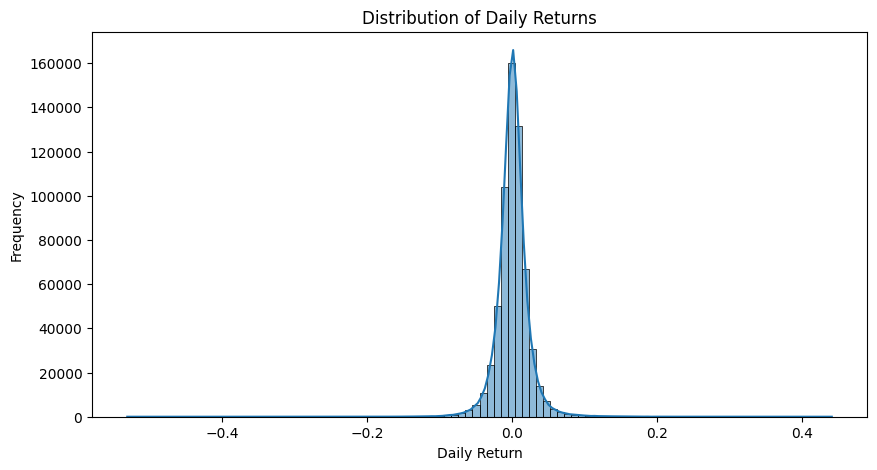

In [35]:
#A normal distribution is expected for daily returns.
# Check for extreme values (outliers).
plt.figure(figsize=(10,5))
sns.histplot(df_5y["Return"].dropna(), bins=100, kde=True)
plt.title("Distribution of Daily Returns")
plt.xlabel("Daily Return")
plt.ylabel("Frequency")
plt.show()


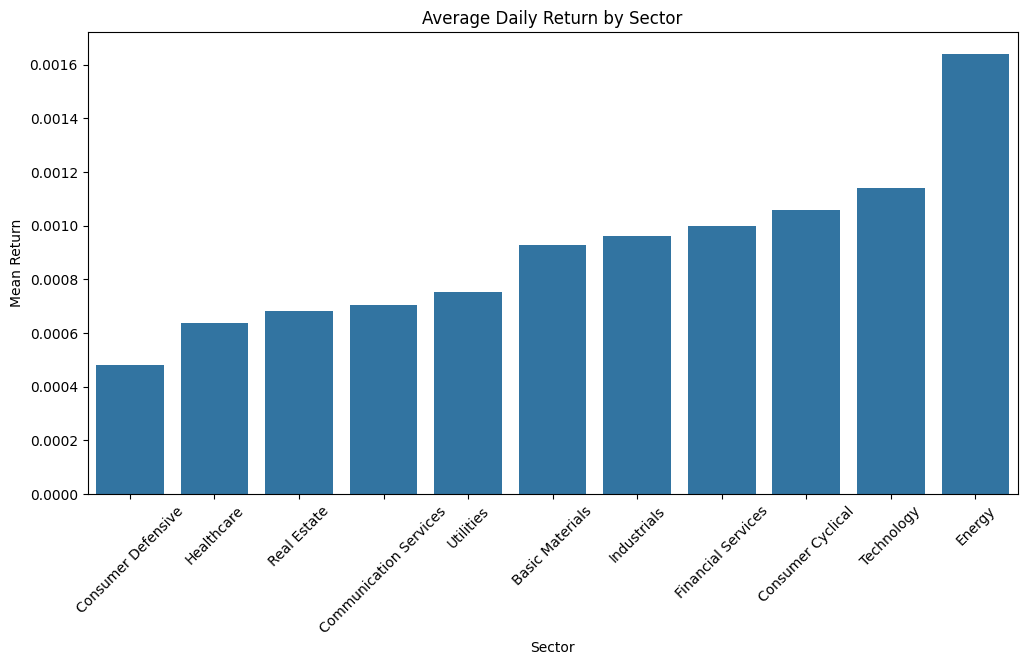

In [ ]:
# Which sectors have highest/lowest average daily returns?
sector_return = df_5y.groupby("Sector")["Return"].mean().sort_values()
plt.figure(figsize=(12, 6))
sns.barplot(x=sector_return.index, y=sector_return.values)
plt.xticks(rotation=45)
plt.title("Average Daily Return by Sector")
plt.ylabel("Mean Return")
plt.show()
